# **画像を元に牡馬・牝馬に分類する(ResNetで作成)**

当スクリプトを実行する前に「README.txt」を参照願います。

In [1]:
###############################################################
# 1.宣言
###############################################################
import cv2
import os
import glob
import matplotlib.pyplot as plt
from matplotlib.image import imread
import numpy as np
#from scipy.misc import toimage
from PIL.Image import fromarray as toimage


from keras.models import Model
from keras.layers import Input, Activation, merge, Dense, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, add, GlobalAveragePooling2D, Dropout

from keras.optimizers import Adam,SGD

from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

from keras.utils import np_utils

from keras.utils import to_categorical
from datetime import datetime
from datetime import timedelta




Using TensorFlow backend.


In [2]:
###############################################################
# 2.事前にマイドライブが見えるようマウントする。
###############################################################
# 事前に、GoogleDriveをmountしておく！！
from google.colab import drive

drive.mount('/content/drive')



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
################################################
## 3.変数・定数定義
################################################


BOBA=0
HINBA=1

# 性別
horseSeiDic = {BOBA:"BOBA",
              HINBA:"HINBA"}

# 訓練データ親ディレクトリ名
trainParentDir = "/content/drive/My Drive/data/train"

# 訓練データ画像ディレクトリ名
trainDirDic = {BOBA:"0_boba",
              HINBA:"1_hinba"}

# モデル保存用ファイルパス
outputDir = "/content/drive/My Drive/output"
modelSaveFileName = "horse_bunrui_model.hdf5"
modelSaveFilePath = outputDir + "/" + modelSaveFileName


# 試験データ親ディレクトリ名
testParentDir = "/content/drive/My Drive/data/test"

#画像のサイズ【暫定】
IMG_WIDTH = 550
IMG_HEIGHT = 400

#ランダムシード値固定(固定しないと、再現性がないモデルになってしまう)
np.random.seed(seed=15)

# kernel_initializer(重みの初期化関数)
KERNEL_INIT = 'glorot_normal'   # Xavierの正規分布



In [0]:
################################################
# 4.ファイル取得
################################################
def getHorseFile(horseType, parentDir, dirDic, imgHeight, imgWidth):

  if horseType == None:
    dirFullPath = parentDir
  else:
    dirFullPath = os.path.join(parentDir, dirDic[horseType])
  
  print(dirFullPath + "からファイルを取得")
    
  # ファイル名取得
  X_fileNameList = glob.glob(dirFullPath + "/*")
  
    
  # ファイルデータ
  X_fileData = getGazouData(X_fileNameList, imgHeight, imgWidth)
  
    
  # ラベル生成
  if horseType == None:
    y_label = None
  else:
    y_label = np.array([horseType]*len(X_fileNameList))
    y_label = y_label.reshape(len(y_label),1)

  return X_fileNameList, X_fileData, y_label


In [0]:
###############################################
## 5.学習の関数
###############################################
def modelFitFunc(model, X_train, y_train):
  # 1 epoch ごとに　weights.01.hdf5, weights.02.hdf5 … のようにモデルを保存してくれる
  # ★学習の途中でmodelを保存する。コールバック関数。epoch1回終わるごとにモデルが保存される。
  #   ここではepochのファイル名にしている。
  ###  コールバック関数  ###
  callback_cp = ModelCheckpoint(filepath=(outputDir + '/' +'weights.{epoch:02d}.hdf5'))

  # 1 epoch ごとに val_acc　に変化があるか調べて、殆ど変わってなかったら学習を打ち切る
  # ★過学習したときにモデルを止める！！validationのaccuracyがpatience回まで我慢する。
  #   mode は上がる下がると良いのかをします。autoだと自動で判断する。
  #   verbose=1でプリントしてくれる。
  #   val_acc:バリデーションデータセットの精度
  callback_es = EarlyStopping(monitor='val_acc', patience=5, mode='auto', verbose=1)

  # ジェネレータ【最重要】
  # batch_sizeを指定してメモリーリークを防ぐ
  #   バッチサイズとは 1 回に計算するデータの数のこと。
  #   バッチサイズを小さくする、たとえば 100 個とかにすると、
  #   1 回の計算で 100 個しか扱わない。
  #   この計算 1 まとまりのことをエポックと呼んでいる。
  #   またデータ数よりもバッチサイズがかなり小さい場合はミニバッチ（学習）と呼ぶ。
  #   バッチサイズを小さくすることで、使用するメモリ量が少なくなる。
  #   また 1 エポックあたりのパラメータ更新回数が増えるので、収束も速くなる。
  #   ただし、バッチサイズを小さくしすぎるとパラメータが暴れてしまうという欠点がある。
  #   したがって、バッチサイズはいい感じに選ぶ必要がある。
  #   ちなみにバッチサイズを指定しないときは、全データの数になる。
  
  # epochs:整数で，モデルを訓練するエポック数． エポックは，提供されるxおよびyデータ全体の反復です．

  # 学習する
  # validation_split:validationの割合
  h = model.fit(X_train, y_train,
                batch_size=10,             #【要チューニング】
                epochs=20,                 #【要チューニング】
                shuffle=True,
                validation_split=0.3,
                callbacks=[callback_cp, callback_es])

  # 学習が終わった最終状態を保存する
  # saveしたmodelは、keras.models.load_model(filepath)により読み込める。
  model.save(modelSaveFilePath)
  
  return h



In [0]:
################################################
# 6.画像データ取得
################################################
def getGazouData(fileNameList, imgHeight, imgWidth):

  fstFlag = True

  for fileName in fileNameList:
    # 画像データ取得
    imgArrElem = imread(fileName,0)
    
    
    # 画像のサイズを統一する
    imgArrElem = cv2.resize(imgArrElem, dsize=(imgWidth, imgHeight))
    
    if fstFlag:
      imgRes = np.array([imgArrElem])
      fstFlag = False
    else:
      imgRes = np.vstack((imgRes,np.array([imgArrElem])))
      
  
  # np.array([[[[・・・ ]]]])で返却
  return imgRes

In [0]:
################################################
# 7.予測結果がOKかNGかを返す関数
################################################
def predJudge(fileName, predStr ,okNum):
  
  retNum = okNum
  
  if predStr == horseSeiDic[int(fileName.split("_")[0])]:
    # 正解
    retNum = retNum + 1
    resultStr = "OK"
  else:
    # 不正解
    resultStr = "NG"
    
  return retNum , "    {}".format(resultStr)


In [0]:
################################################
# 8.画像表示関数
################################################
def dispGazou(fileNameList, dataArr ,subRowNum , subColNum, parentDir, y_labelArr, seikaiDispFlg):
  print("▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼")
  # figsize=(w,h)
  plt.figure(figsize=(25,50))

  fileNum = len(fileNameList)
  
  randDispIdxArr = np.array([])
  dispFilNumMax = (subRowNum * subColNum)
  if dispFilNumMax < fileNum:
    print("表示ファイル数の上限{}を超えているので、ランダムで{}個まで表示します。".format(dispFilNumMax, dispFilNumMax))
    # 重複なしでランダム選択
    randDispIdxArr = np.array(np.random.choice(range(fileNum), size=dispFilNumMax, replace=False))
  
  ##
  
  okNum = 0
  plotIdx = 0
  
  # 全ファイル数でループ
  for idx in range(fileNum):
    
    if len(randDispIdxArr) > 0:
      if idx not in randDispIdxArr:
        continue
    
    img = toimage(dataArr[idx])
    
    # subRowNum×subColNumファイル数を表示
    plotIdx = plotIdx + 1
    plt.subplot(subRowNum, subColNum, plotIdx)
    plt.imshow(img)
    plt.axis('off')
    # 1個上のフォルダから表示する。
    titleFileName = fileNameList[idx].replace("{}/".format(parentDir) , "")
    
    predStr = horseSeiDic[y_labelArr[idx][0]]
    
    # 正解表示フラグTrueの場合
    if seikaiDispFlg:
      okNum, seikaiStr = predJudge(titleFileName, predStr  ,okNum)
    else:
      seikaiStr = ""

    if seikaiStr.lstrip() == "NG":
      titleColor = "red"
    else:
      titleColor = "black"
      
    # タイトル    
    titleStr = "[{}] {} : {}{}".format(plotIdx, titleFileName, predStr, seikaiStr)
    plt.title(titleStr, color=titleColor)
    
  plt.show()
  
  # 正解表示フラグTrueの場合
  if seikaiDispFlg:
    print("\n\n")
    # パーセントは少数第2位で丸める
    print("OK  =  {} / {} ({:.2%})\n".format(okNum, fileNum , okNum/fileNum ))
  
  print("▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲")

  

In [0]:
###############################################
## 9.グラフ描画関数
###############################################
def plotFunc(resH, titleStr, typeStr, ylimMax):
  #・resH.history:
  #  {'val_loss': [・・・, ・・・],
  #   'val_acc': [・・・, ・・・],
  #   'loss': [・・・, ・・・],
  #   'acc': [・・・, ・・・]}
  #・resH:
  #  <keras.callbacks.History object at 0x7f94127f68d0>

  epoch = np.arange(len(resH.history[typeStr]))

  plt.title(titleStr)
  plt.xlabel('epoch')
  plt.ylim(0.0, ylimMax)
  plt.ylabel(typeStr)

  plt.plot(epoch, resH.history[typeStr], label='train_{}'.format(typeStr) )
  plt.plot(epoch, resH.history['val_{}'.format(typeStr)], label='validation_{}'.format(typeStr) )
  plt.legend()
  plt.show()

In [0]:
###############################################
## 10.ResNet のモデル構築★極めて重要★
###############################################

# ＜正則化＞
# Dropout ・ BatchNormalization のいずれかを指定する。

###################
####　サブ関数 ####
###################
# inputs と residual 2つの処理結果を受け取って、両者を足す
def _shortcut(inputs, residual):
  
  # residual のほうのフィルタ数を取得する
  # ちなみに
  # _keras_shape[0] ★Noneが入っている.何だこれ？ひとまず後回し。★
  # _keras_shape[1] 画像の高さ
  # _keras_shape[2] 画像の幅
  # _keras_shape[3] チャンネル数(filter数)
  # になっている(デフォルトでは)。
  # 本当はチャンネル数、幅、高さの順番のこともあるので
  # それを考慮したコードにしなければならないのだが、今回はこれで問題ない
  # フィルタ数はCNNから持ってきて、入力に適用する
  n_filters = residual._keras_shape[3]
  
  ## 例)residual._keras_shape ： (None, 16, 16, 64)
  
  # inputs と residual とでチャネル数が違うかもしれない。
  # そのままだと足せないので、1×1 conv を使って residual 側のフィルタ数に合わせている
  # ★フィルタ数を合わせるためだけにConvolution2Dする。n_filtersにする！！
  #   高さと幅は変わらない。カーネルサイズ1×1,ストライド1×1
  #   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  shortcut = Conv2D(n_filters, (1,1), strides=(1,1), padding='valid')(inputs)
  
  # 2つを足す
  # ★計算して出てきた特徴map:h×w×C　と　スキップで渡されてきた入力特徴map:h×w×C の対応する要素を足し合わせている。
  # h,w,Cをそれぞれ一致させること！！！上の2行で実現している。
  # kerasのadd。「+」ではだめ！！！
  return add([shortcut, residual])


###################
####　サブ関数 ####
###################
# ResBlock を定義
# ここでの処理は BatchNorm → ReLU → Conv とシンプルなものにしてあるが、
# ここを色々変更する改良案が無数にある
def _resblock(n_filters, kernel_init, filter_size , strides=(1,1)):

  def f(input):
    
    #print("★input =", input)
    # ★input = Tensor("max_pooling2d_1/MaxPool:0", shape=(?, 200, 275, 32), dtype=float32)
    # ↓
    # ★input = Tensor("add_1/add:0", shape=(?, 200, 275, 64), dtype=float32)
    # ↓
    # ★input = Tensor("add_2/add:0", shape=(?, 200, 275, 64), dtype=float32)
    # ↓
    # ★input = Tensor("max_pooling2d_2/MaxPool:0", shape=(?, 100, 137, 64), dtype=float32)
    # ↓
    # ★input = Tensor("add_4/add:0", shape=(?, 100, 137, 128), dtype=float32)
    # ↓
    # ★input = Tensor("add_5/add:0", shape=(?, 100, 137, 128), dtype=float32)
    
    
    # n_filtersはC(チャネル)
    # w,hが変わらない。padding='same'を使っているから。
    # X_PARA ← input
    X_PARA = Conv2D(n_filters, filter_size, strides=strides,
                                      kernel_initializer=kernel_init, padding='same')(input)
    X_PARA = BatchNormalization()(X_PARA)
    
    X_PARA = Activation('relu')(X_PARA)
    
    X_PARA = Conv2D(n_filters, filter_size, strides=strides,
                                      kernel_initializer=kernel_init, padding='same')(X_PARA)
    X_PARA = BatchNormalization()(X_PARA)
    
    # 入力そのもの(スキップ):inputと、BN→ReLU→Conv したもの:X_PARA とを足す
    # ★この部分がResNetのもっとも重要な点
    return _shortcut(input, X_PARA)

  # 関数を返す
  return f

#############################
####　RESNETの最上位関数 ####
#############################
def resnetFunc(imgHeight, imgWidth, kernel_init_val, class_num):
  # 入力テンソルを定義しておく
  # 画像のサイズ(h,w,チャネル数(RGBで3))
  inputs = Input(shape=(imgHeight, imgWidth, 3))
  # ★inputs = Tensor("input_1:0", shape=(?, 400, 550, 3), dtype=float32)
  
  # ResBlock で処理をする前に、いったん
  # 7(h)×7(w)で畳み込み→BN→ReLU　をし、さらに MaxPooling している
  # これは無くても動くが、早い段階でとりあえずMaxPoolingすることで画像サイズが1/2になるので
  # パラメータ数の増加を抑える(高速に学習できる)効果がある

  # ++++++++++++++++++++++++
  # ★【kerasの思想】
  # ハイパーパラメータと入力を分けたい！！！
  # レイヤのインスタンスを作る。データを入力する。
  # X_PARA を入力と返り値で持つ。ひたすらX_PARAを更新し続ける。
  # ++++++++++++++++++++++++
  
  # ↓functional API↓

  
  ####################
  # 第1引数 filter数
  # 第2引数 filter:3(h)×3(w) conv→BN→ReLU
  # strides=(1(h),1(w))
  kernel_num_val = 32
  filterSize = (3,3)
  X_PARA = Conv2D(kernel_num_val, filterSize, strides=(1,1),
                  kernel_initializer=kernel_init_val, padding='same')(inputs)
  # BatchNormalization：学習がスムーズに行えるように強制的にアクティベーション(活性化関数の後の出力データ)の分布を調整すること。正則化の手法。
  X_PARA = BatchNormalization()(X_PARA)

  X_PARA = Activation('relu')(X_PARA)
  # MaxPoolingで縮小
  # 第1引数は、pool_size=(3(h), 3(w))
  # 第2引数は、strides=(2(h),2(w))
  X_PARA = MaxPooling2D((3, 3), strides=(2,2), padding='same')(X_PARA)
  
  ####################
  #ここからは ResBlock を積み重ねていく
  
  # _resblockはサブ関数(ハイパーパラメータ)(入力)の構造。
  # kernel_num_val:64↓
  kernel_num_val = kernel_num_val * 2
  X_PARA = _resblock(n_filters=kernel_num_val, kernel_init=kernel_init_val, filter_size=filterSize)(X_PARA)
  X_PARA = _resblock(n_filters=kernel_num_val, kernel_init=kernel_init_val, filter_size=filterSize)(X_PARA)
  X_PARA = _resblock(n_filters=kernel_num_val, kernel_init=kernel_init_val, filter_size=filterSize)(X_PARA)
  # 第1引数pool_size=デフォルト(2, 2)
  X_PARA = MaxPooling2D(strides=(2,2))(X_PARA)
  
  # kernel_num_val:128↓
  kernel_num_val = kernel_num_val * 2
  X_PARA = _resblock(n_filters=kernel_num_val, kernel_init=kernel_init_val, filter_size=filterSize)(X_PARA)
  X_PARA = _resblock(n_filters=kernel_num_val, kernel_init=kernel_init_val, filter_size=filterSize)(X_PARA)
  X_PARA = _resblock(n_filters=kernel_num_val, kernel_init=kernel_init_val, filter_size=filterSize)(X_PARA)

  
  ##################
  # 追加のネットワーク
  # 第1引数pool_size=デフォルト(2, 2)
  X_PARA = MaxPooling2D(strides=(2,2))(X_PARA)
  
  # kernel_num_val:256↓
  kernel_num_val = kernel_num_val * 2
  X_PARA = _resblock(n_filters=kernel_num_val, kernel_init=kernel_init_val, filter_size=filterSize)(X_PARA)
  X_PARA = _resblock(n_filters=kernel_num_val, kernel_init=kernel_init_val, filter_size=filterSize)(X_PARA)
  X_PARA = _resblock(n_filters=kernel_num_val, kernel_init=kernel_init_val, filter_size=filterSize)(X_PARA)

  
  # 第1引数pool_size=デフォルト(2, 2)
  X_PARA = MaxPooling2D(strides=(2,2))(X_PARA)
  
  # kernel_num_val:512↓
  kernel_num_val = kernel_num_val * 2
  X_PARA = _resblock(n_filters=kernel_num_val, kernel_init=kernel_init_val, filter_size=filterSize)(X_PARA)
  ##################
  
  
  # Global Average Pooling したあとに Fully Connection Network ( = Dense) する
  # ここで1次元に変換する。この後は全結合層のみが追加できる。
  X_PARA = GlobalAveragePooling2D()(X_PARA)

  # ★全結合★
  X_PARA = Dense(1024, kernel_initializer=kernel_init_val, activation='relu')(X_PARA)

  
  # ★出力層★
  # 第1引数：正解ラベルのクラス数
  X_PARA = Dense(class_num, kernel_initializer=kernel_init_val, activation='softmax')(X_PARA)
  
  # 今までの経緯がX_PARAでModelに渡される。
  model = Model(inputs=inputs, outputs=X_PARA)
  return model


In [11]:
################################################
################################################
####### 11.★↓ここからmain処理↓★
################################################
################################################
  

# 牡馬 train
X_train_fileNameList_boba, X_train_fileData_boba, y_train_boba = getHorseFile(BOBA, trainParentDir, trainDirDic, IMG_HEIGHT, IMG_WIDTH)

# 牝馬 train
X_train_fileNameList_hinba, X_train_fileData_hinba, y_train_hinba = getHorseFile(HINBA, trainParentDir, trainDirDic, IMG_HEIGHT, IMG_WIDTH)


# 合体(牡馬+牝馬)
X_train_fileNameList_total = X_train_fileNameList_boba + X_train_fileNameList_hinba

X_train_fileData_total = np.vstack((X_train_fileData_boba, X_train_fileData_hinba))

y_train_total = np.vstack((y_train_boba,y_train_hinba))

# ダミー変数に変換
y_train_total_cat = to_categorical(y_train_total)


print("\n")

print("訓練データファイル数 = ",len(X_train_fileNameList_total))
# print("len(X_train_fileNameList_total)=",len(X_train_fileNameList_total))
# print("X_train_fileNameList_total=",X_train_fileNameList_total)
# print("len(X_train_fileData_total)=",len(X_train_fileData_total))
# print("X_train_fileData_total=",X_train_fileData_total)
# print("len(y_train_total)=",len(y_train_total))
# print("y_train_total=",y_train_total)
# print("len(y_train_total_cat)=",len(y_train_total_cat))
# print("y_train_total_cat=",y_train_total_cat)


#画像を試しに表示してみる
print("【訓練データの表示】")
dispGazou(X_train_fileNameList_total, X_train_fileData_total, 20 , 5, trainParentDir, y_train_total, False)


# 出力用フォルダ存在確認
if(os.path.isdir(outputDir) == False):
    print("{}が無いので作成する".format(outputDir))
    os.mkdir(outputDir)
else:
    print("{}配下のファイルを削除する".format(outputDir))
    output_file_list = os.listdir(outputDir)
    for ouput_file in output_file_list:
        filDirPath = os.path.join(outputDir , ouput_file)
        if(os.path.isfile(filDirPath)):
            # ファイル削除
            os.remove(filDirPath)
        else:
            # サブフォルダ削除
            shutil.rmtree(filDirPath)

    
    
####################################

# モデル構築(ResNet)
model = resnetFunc(IMG_HEIGHT, IMG_WIDTH, KERNEL_INIT, np.shape(y_train_total_cat)[1])

# optimizer として Adam を指定する。SGDでも良いがAdamのほうが収束が早い
# inputs から outputs を求める計算をするようにコンパイルする
# ここでネットワークでどのような処理を行うかが全て決定される
# 第1引数：最適化関数
model.compile(optimizer=SGD(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# 今作ったネットワークがどんなネットワークなのか概要を表示する機能(見られるだけなので無くても良い)
model.summary()



Output hidden; open in https://colab.research.google.com to view.

In [12]:
####################################
# 12.学習
####################################


# 学習する前に、正規化しないと精度が低くなってしまう。
X_train_fileData_total = X_train_fileData_total.astype('float32')
X_train_fileData_total /= 255.0

# print(X_train_fileData_total)
print(np.shape(X_train_fileData_total))
resH = modelFitFunc(model, X_train_fileData_total, y_train_total_cat)

W0702 15:16:31.569123 140238598383488 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


(200, 400, 550, 3)
Train on 140 samples, validate on 60 samples
Epoch 1/20
140/140 [==============================] - 31s 223ms/step - loss: 0.8550 - acc: 0.6357 - val_loss: 1.7844 - val_acc: 0.0000e+00
Epoch 2/20
140/140 [==============================] - 22s 159ms/step - loss: 0.6354 - acc: 0.6429 - val_loss: 1.7020 - val_acc: 0.0000e+00
Epoch 3/20
140/140 [==============================] - 22s 158ms/step - loss: 0.5727 - acc: 0.7143 - val_loss: 0.9818 - val_acc: 0.2500
Epoch 4/20
140/140 [==============================] - 22s 158ms/step - loss: 0.5180 - acc: 0.7714 - val_loss: 1.5506 - val_acc: 0.0833
Epoch 5/20
140/140 [==============================] - 22s 159ms/step - loss: 0.6813 - acc: 0.6929 - val_loss: 1.3918 - val_acc: 0.1667
Epoch 6/20
140/140 [==============================] - 22s 158ms/step - loss: 0.5625 - acc: 0.7214 - val_loss: 0.8911 - val_acc: 0.4167
Epoch 7/20
140/140 [==============================] - 22s 159ms/step - loss: 0.6378 - acc: 0.6786 - val_loss: 1.7879 -

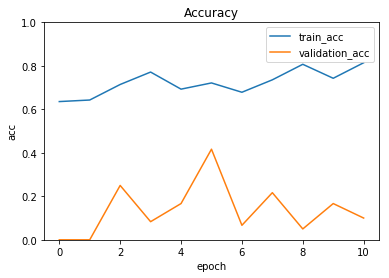

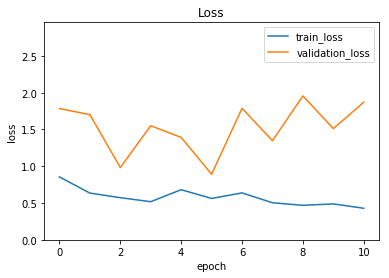

In [13]:
###############################################
## 13.学習結果のプロット
###############################################

# accuracy と validation accuracy の推移をプロットする
plotFunc(resH, 'Accuracy', 'acc', 1.0)

# loss と validation loss の推移をプロットする
plotFunc(resH, 'Loss', 'loss', np.array(resH.history['val_loss']).max() + 1.0)


In [14]:
####################################
# 14.試験データファイル取得
####################################
X_test_fileNameList, X_test_fileData, _ = getHorseFile(None, testParentDir, None, IMG_HEIGHT, IMG_WIDTH)


# 実行する前に、正規化しないと精度が低くなってしまう。
X_test_fileData = X_test_fileData.astype('float32')
X_test_fileData /= 255.0



print("len(X_test_fileNameList)=",len(X_test_fileNameList))
print("X_test_fileNameList=",X_test_fileNameList)

print("len(X_test_fileData)=",len(X_test_fileData))

print(np.shape(X_test_fileData))

/content/drive/My Drive/data/testからファイルを取得
len(X_test_fileNameList)= 12
X_test_fileNameList= ['/content/drive/My Drive/data/test/1_gentildonna_1.jpg', '/content/drive/My Drive/data/test/0_deepimpact_1.jpg', '/content/drive/My Drive/data/test/1_gentildonna_2.jpg', '/content/drive/My Drive/data/test/0_loadkanaroa_2.jpg', '/content/drive/My Drive/data/test/0_admiremoon_2.jpg', '/content/drive/My Drive/data/test/0_admiremoon_1.jpg', '/content/drive/My Drive/data/test/1_vodka_1.jpg', '/content/drive/My Drive/data/test/0_deepimpact_2.jpg', '/content/drive/My Drive/data/test/1_vodka_2.jpg', '/content/drive/My Drive/data/test/0_loadkanaroa_1.jpg', '/content/drive/My Drive/data/test/1_danceinthemood_1.jpg', '/content/drive/My Drive/data/test/1_danceinthemood_2.jpg']
len(X_test_fileData)= 12
(12, 400, 550, 3)


【検証結果の表示】
▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼


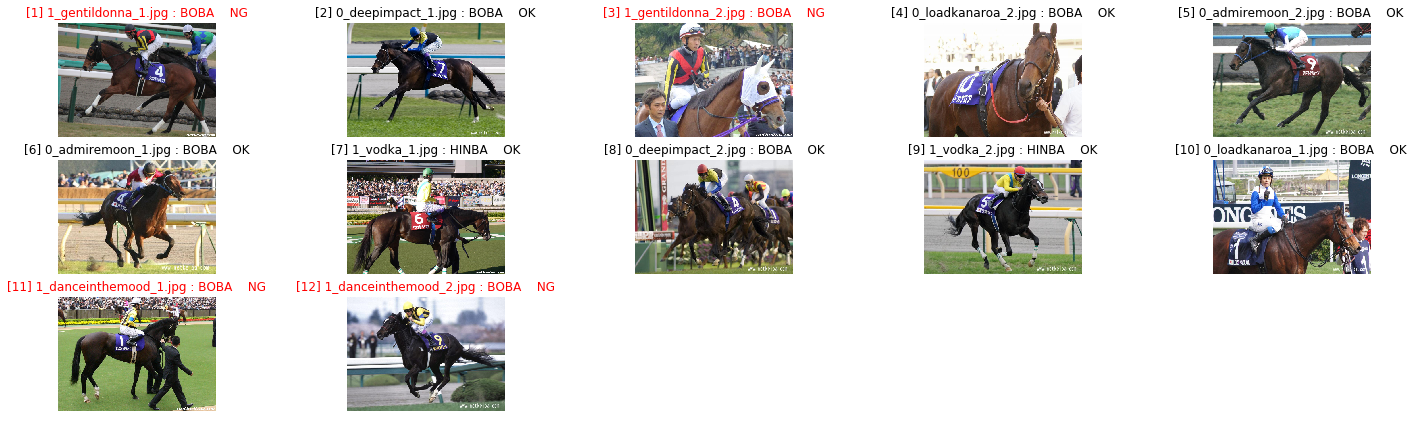




OK  =  8 / 12 (66.67%)

▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲
2019-07-03 00:21:07.672912


In [15]:
###############################################
## 15.作ったモデルで実行
###############################################
results = model.predict(X_test_fileData)

fileNum = len(X_test_fileData)

y_test_labelArr = np.array([0]*fileNum)

for i in range(fileNum):
  # ↓ラベル
  y_test_labelArr[i] = np.array(results[i].argmax())

y_test_labelArr = y_test_labelArr.reshape(fileNum,1)

# 正規化解除
X_test_fileData *= 255.0

# intに変換しておく
X_test_fileData = X_test_fileData.astype('uint8')


# 描画
print("【検証結果の表示】")
dispGazou(X_test_fileNameList, X_test_fileData , 20 , 5, testParentDir, y_test_labelArr, True)

# 終了時刻表示(nowに9時間足すと日本時刻になる)
print(datetime.now() + timedelta(hours=9))
